**SETTING UP THE MODEL: SWIN OF MICROSOFT 🍀**

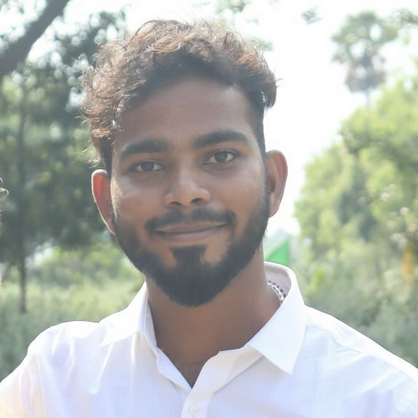

In [8]:
import torch
import timm
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms

model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
model.eval()
model.head = torch.nn.Identity()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_url = "https://arihara-sudhan.github.io/statics/ss2.png"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img

**EMBEDDINGS ⑱**

In [9]:
img = img.convert("RGB")
img = transform(img).unsqueeze(0)

with torch.no_grad():
    embeddings = model(img)
print(embeddings.shape)

torch.Size([1, 7, 7, 1024])


**TRIPLETIFYING THE DATA 🔴🟢🔵**

In [10]:
from torch.utils.data import Dataset,DataLoader
import random

class Triplet:
    def __init__(self, train_folder):
        self.train_folder = train_folder
        self.labels = [label for label in os.listdir(train_folder) if label != '.ipynb_checkpoints']
        self.label_to_path = {label: os.path.join(train_folder, label) for label in self.labels}

    def get_triplet(self):
        anchor_label = random.choice(self.labels)
        anchor_path = random.choice(os.listdir(self.label_to_path[anchor_label]))
        positive_label = anchor_label
        positive_path = random.choice(os.listdir(self.label_to_path[positive_label]))
        negative_label = random.choice([label for label in self.labels if label != anchor_label])
        negative_path = random.choice(os.listdir(self.label_to_path[negative_label]))

        anchor_image = os.path.join(self.label_to_path[anchor_label], anchor_path)
        positive_image = os.path.join(self.label_to_path[positive_label], positive_path)
        negative_image = os.path.join(self.label_to_path[negative_label], negative_path)

        anchor_label_num = self.labels.index(anchor_label)
        positive_label_num = self.labels.index(positive_label)
        negative_label_num = self.labels.index(negative_label)

        return anchor_image, positive_image, negative_image

class TripletDataset(Dataset):
    def __init__(self, train_folder, length, transform=None,):
        self.triplet_generator = Triplet(train_folder)
        self.transform = transform
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        anchor_image, positive_image, negative_image = self.triplet_generator.get_triplet()
        anchor = self._load_image(anchor_image)
        positive = self._load_image(positive_image)
        negative = self._load_image(negative_image)
        return anchor, positive, negative

    def _load_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

    def get_triplet_names(self, index):
        anchor_image, positive_image, negative_image = self.triplet_generator.get_triplet()
        return anchor_image, positive_image, negative_image

**MODEL 𝌭**

In [12]:
import torch.nn as nn

class TEmbeddingNet(nn.Module):
    def __init__(self, modelt):
        super(TEmbeddingNet, self).__init__()
        self.modelt = modelt
        self.modelt.head = nn.Identity()
        
    def forward(self, x):
        x = self.modelt(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)

class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.enet = embedding_net

    def forward(self, x1, x2=None, x3=None):
        if x2 is None and x3 is None:
            return self.enet.get_embedding(x1)
        return self.enet.get_embedding(x1),self.enet.get_embedding(x2),self.enet.get_embedding(x3)

    def get_embedding(self, x):
        return self.enet.get_embedding(x)

tmodel = TEmbeddingNet(model)
model = TripletNet(tmodel)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {device}")
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(TripletNet(tmodel))
else:
    model = TripletNet(tmodel)
model = model.to(device)

DEVICE: cuda


**SETTING UP ⚙️**

In [13]:
import os

train_folder = '/kaggle/input/fewshotdataset/fshot_dset'
train_dataset = TripletDataset(train_folder, 300, transform=transform)
bs = 1
train_triplet_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

In [14]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = torch.norm(anchor - positive, dim=1)
        distance_negative = torch.norm(anchor - negative, dim=1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

margin = 1
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)  # Learning rate scheduler
loss_fn = TripletLoss(margin)
clip_value = 0.5

**VISUALIZE EMBEDDINGS 👀**

In [188]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torchvision import datasets
    
def visualize(model, device='cuda', batch_size=1, method='tsne'):
    # SET THE FOLDER WHICH CAN BE EITHER THE TRAIN FOLDER OR SOMEOTHER FOLDER
    dataset = datasets.ImageFolder("/kaggle/input/fewshot-sample/dataset/test", transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            emb = model.get_embedding(inputs)
            if emb.dim() > 2:
                emb = emb.view(emb.size(0), -1)
            embeddings.append(emb.cpu().numpy())
            labels.append(targets.numpy())
    
    embeddings = np.vstack(embeddings) 
    labels = np.hstack(labels)
    
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Invalid method. Choose 'tsne' or 'pca'.")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(f'Embedding Visualization using {method.upper()}')
    plt.show()

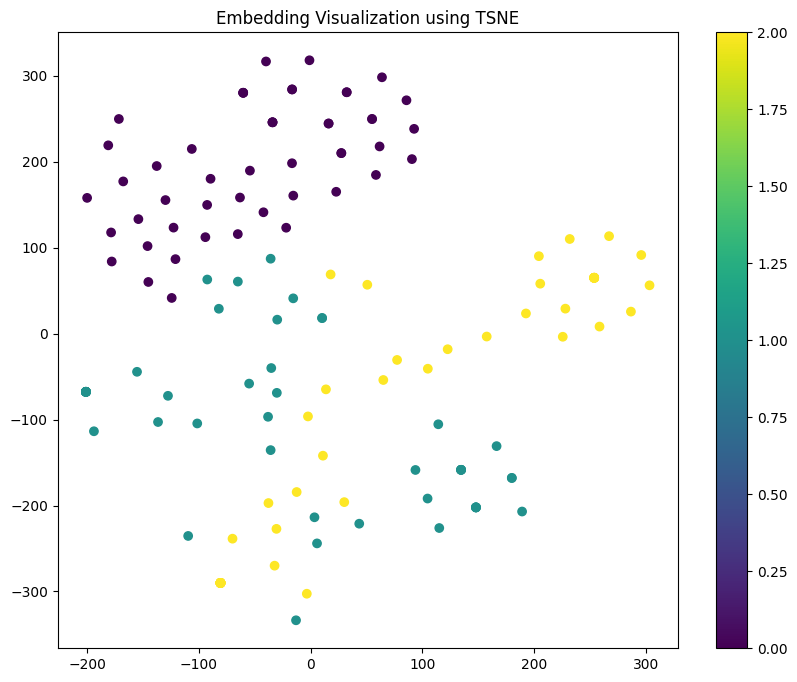

In [189]:
visualize(model)

**TRAIN 👶🏻**

In [ ]:
import time
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

def fit(model, num_epochs, train_loader, bs):
    for epoch in range(n_epochs):
        start = time.time()
        model.train()
        train_loss = 0.0

        for idx, batch in enumerate(train_loader):
            anchor, positive, negative = batch
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            optimizer.zero_grad()
            anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
            anchor_embedding.requires_grad_(True)
            positive_embedding.requires_grad_(True)
            negative_embedding.requires_grad_(True)
            loss = loss_fn(anchor_embedding, positive_embedding, negative_embedding)
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, TIME: {time.time()-start}")
        scheduler.step()
        visualize(model)

fit(model, n_epochs:=int(input("NO OF EPOCHS : ")), train_triplet_loader, bs)

In [190]:
torch.save(model.state_dict(), 'model.pth')

In [203]:
#model.load_state_dict(torch.load("/kaggle/working/model.pth"))

<All keys matched successfully>

**INFER 🦉**

In [211]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def create_embs(model, device='cuda', batch_size=1, method='tsne'):
    transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])
    dataset = datasets.ImageFolder("/kaggle/input/fewshot-sample/dataset/test", transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    class_names = dataset.classes
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            emb = model.get_embedding(inputs)
            if emb.dim() > 2:
                emb = emb.view(emb.size(0), -1)
            embeddings.append(emb.cpu().numpy())
            labels.append(targets.numpy())
    
    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)
    embedding_dict = {tuple(emb): class_names[label] for emb, label in zip(embeddings, labels)}
    
    return embedding_dict


edict = create_embs(model)

In [215]:
from PIL import Image
import torch
import numpy as np
from torchvision import transforms
from scipy.spatial import distance

def get_embedding_for_image(image_path, model, device='cuda'):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        emb = model(image)
        if emb.dim() > 2:
            emb = emb.view(emb.size(0), -1)
        return emb.cpu().numpy()

def find_class(image_path, model, emb_dict, device='cuda'):
    query_embedding = get_embedding_for_image(image_path, model, device)
    min_dist = float('inf')
    closest_class_name = "Embedding not found in the dictionary"
    for emb_tuple, class_name in emb_dict.items():
        emb_array = np.array(emb_tuple)
        dist = distance.euclidean(query_embedding.flatten(), emb_array)
        if dist < min_dist:
            min_dist = dist
            closest_class_name = class_name
    return closest_class_name


In [217]:
find_class("/kaggle/input/fewshot-sample/dataset/test/Owl/IMG236522.png", model, edict)

'Owl'